In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
from torch import nn
from pathlib import Path
from torch.optim import Adam, AdamW, SGD
from matplotlib import pyplot as plt
from models.vate import VATE
from models.vate import RecurrentEncoder, TransitionModule, RecurrentDecoder
from utils.plotting import plot_latent_trajectory, plot_latent_trajectory_multiview, plot_neural_data
from data.dataset import NeuralDataset

from data.datasets.lorenz import simulate_lorenz, get_lorenz_labels, create_neural_timeseries

from utils.plotting import animate_latent_trajectory, plot_latent_trajectory_interactive, plot_vector_field_interactive
from utils.plotting import training_summary_plot, training_summary_plot_iw


device = 'cuda'


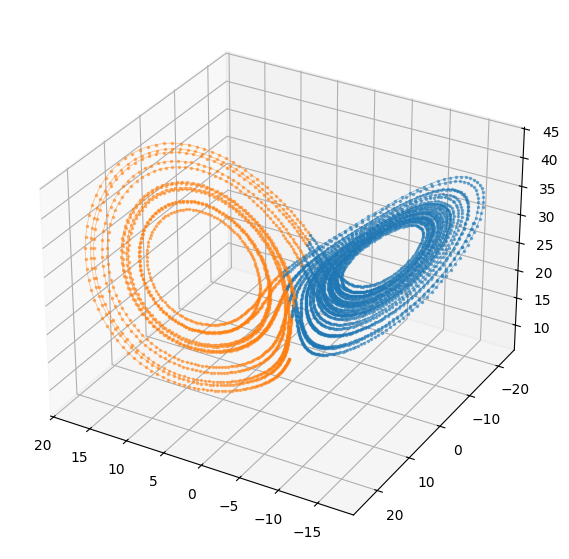

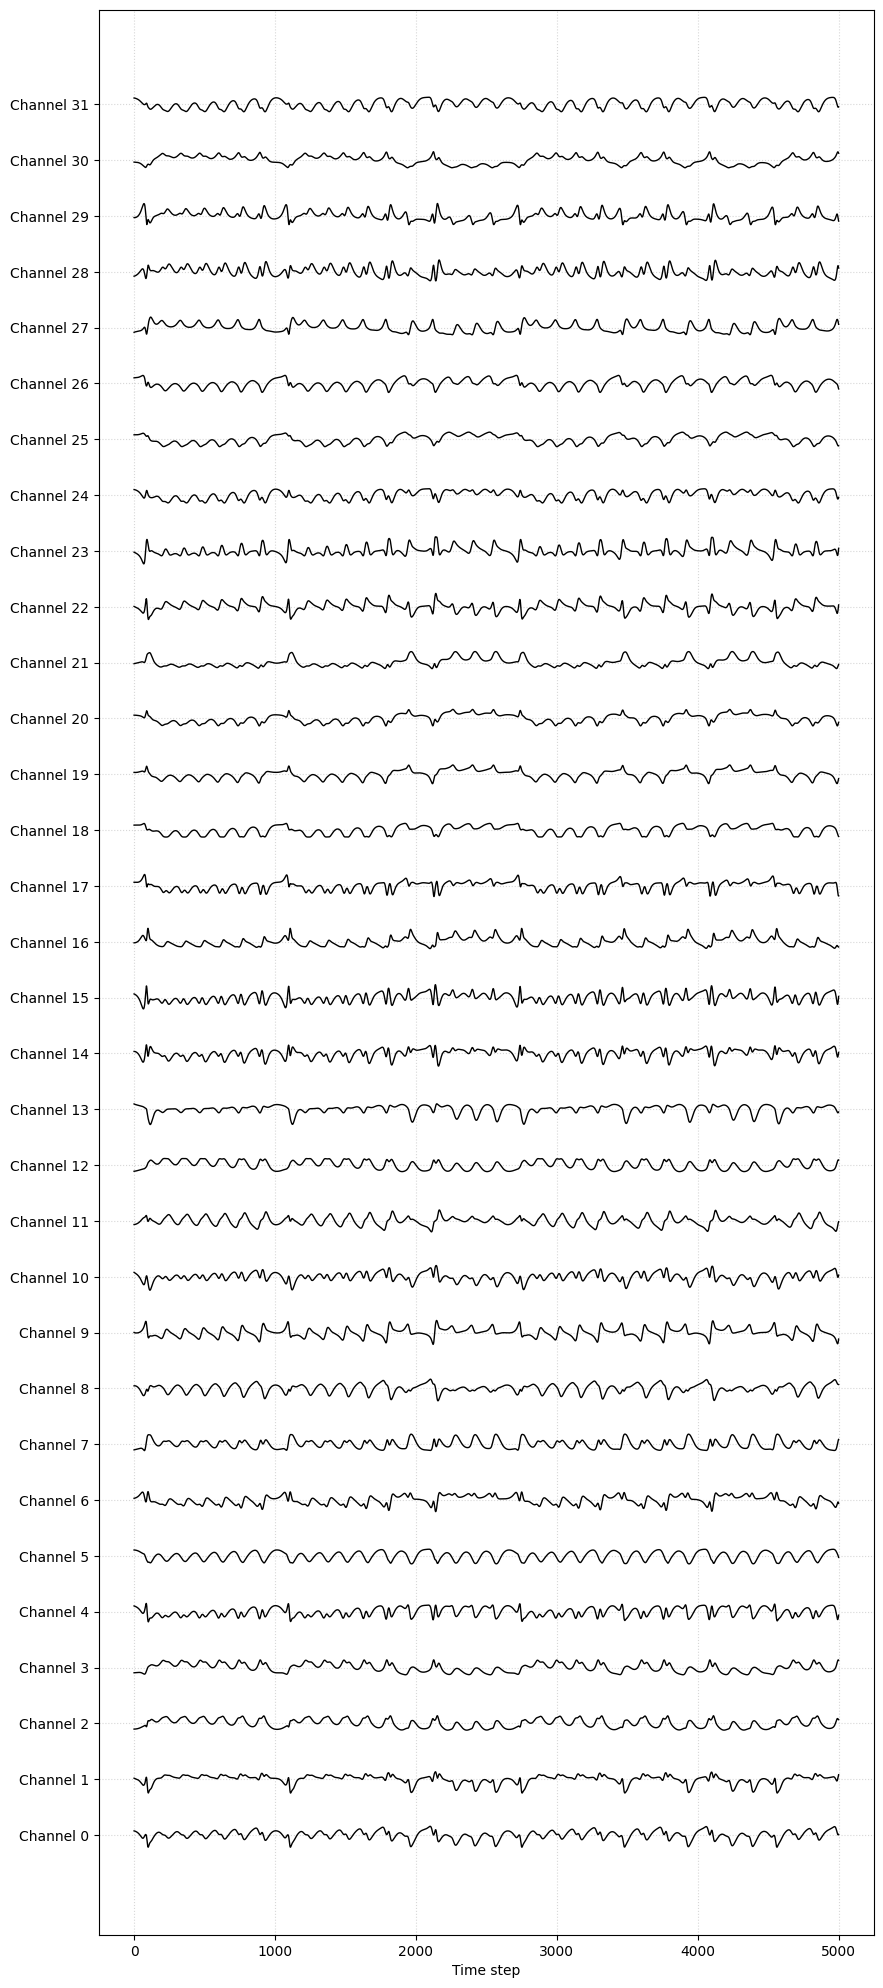

In [2]:
x0 = np.array([0,1,10])
times = np.linspace(0,25,5000)
x_lorenz = simulate_lorenz(x0, times)
labels_lorenz = get_lorenz_labels(x_lorenz)
x_neural, mapping_matrix = create_neural_timeseries(x_lorenz, channels=32)

plot_latent_trajectory(x_lorenz, labels_lorenz, markersize=3)
plot_neural_data(x_neural)

In [3]:
dataset = NeuralDataset(neural=x_neural,
                        target_labels={'behavior': labels_lorenz},
                        device=device
                        )

print(dataset)

NeuralDataset
  - Timepoints          : 5000
  - Device              : cuda
  - Dataset on device?  : True
  - Neural timeseries
	neural (continuous, shape=(5000, 32), multivariate=True)
  - Target labels timeseries
	behavior (discrete, shape=(5000, 1), multivariate=False)
  - Nuisance labels timeseries: None


/home/nuzzi/Projects/NeuralEncoder_V2/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
latent_dim = 3
num_classes = 2

encoder = RecurrentEncoder(
    rnn_module=nn.GRU(input_size=32, hidden_size=64, batch_first=True),
    body_module=nn.Sequential(
        nn.LazyLinear(64), nn.GELU(),
        nn.LazyLinear(32), nn.GELU(),
        nn.LazyLinear(16), nn.GELU(),
    ),
    latent_dim=latent_dim,
    # fixed_logvar=-3
)

transition = TransitionModule(
                base_module=nn.Sequential(
                    nn.LazyLinear(64), nn.GELU(),
                    nn.LazyLinear(64), nn.GELU(),
                    nn.LazyLinear(64), nn.GELU(),
                ),
                residual_mode='residual',
                latent_dim=latent_dim,
                # fixed_logvar=-3
)

decoder_behavior = RecurrentDecoder(
    rnn_module=nn.GRU(input_size=latent_dim, hidden_size=16, batch_first=True),
    decoder_module=nn.LazyLinear(num_classes)
)

decoders = {'behavior': decoder_behavior}
loss_fn_decoders = {'behavior': nn.CrossEntropyLoss()}

model = VATE(encoder, 
             transition,
             decoders, loss_fn_decoders, 
            ).to(device)

model.summary(input_features=32)

Module         Parameters     
------------------------------
Encoder        25878          
Transition     13126          
Decoders       
-behavior      1042           
------------------------------
Total          40046          


In [35]:
# Training
optimizer = Adam(model.parameters(), lr=3e-4)
losses_history = model.fit(dataset, iterations=5000, batch_size=256, window_len=50, num_particles=3, optimizer=optimizer)

# Training plots
plt.figure(figsize=(6,4))
plt.plot(losses_history['loss_targets_behavior'], label='Label behavior', linewidth=0.5, color='k')
plt.plot(losses_history['loss_transition'], label='Transition', linewidth=0.5, color='r')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
    


 63%|██████▎   | 3147/5000 [07:20<04:19,  7.15it/s, total_loss=71, loss_transition=33.7, loss_prior=3.77, entropy=0.823, loss_targets_behavior=32.7]       


KeyboardInterrupt: 

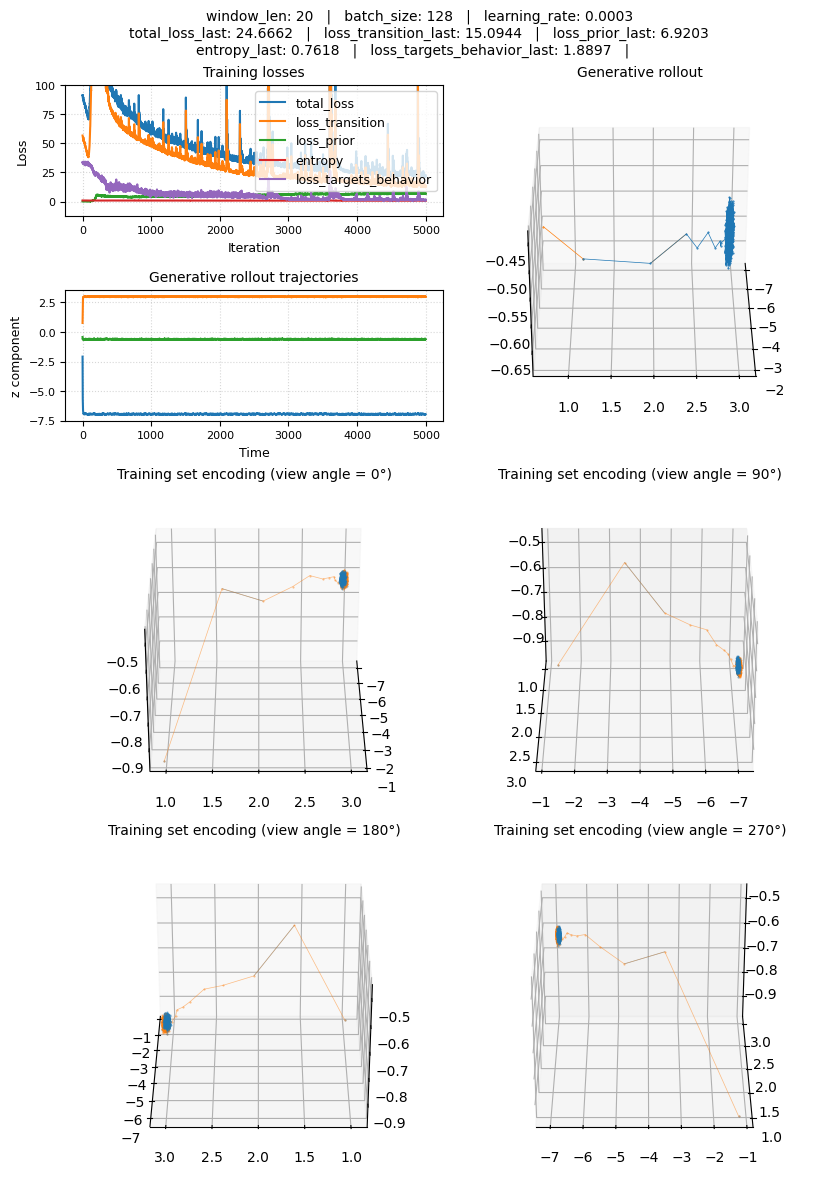

In [36]:
# Model summary plot
training_summary_plot_iw(model, dataset, losses_history, label_to_show='behavior',
                      title_args={'window_len': 20, 'batch_size': 128, 'learning_rate': 3e-4})


In [32]:
z_latent, _ = model.encoder(dataset.neural.data.unsqueeze(0).unsqueeze(0))
z_latent = z_latent.squeeze()
plot_latent_trajectory_interactive(z_latent, labels_lorenz, markersize=2)


In [ ]:
x0 = torch.FloatTensor(x_neural[0,:]).to(device)
generation_result = model.generate(x0=x0, num_steps=3000)
z_rollout, target_labels_rollout = generation_result['z_sequence'], generation_result['target_preds']
target_label_rollout_class = torch.argmax(target_labels_rollout['behavior'], axis=-1)

plot_latent_trajectory_interactive(z_rollout, target_label_rollout_class, markersize=1)




torch.Size([200, 2])


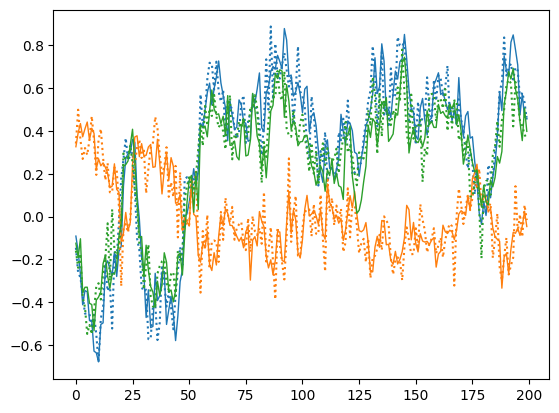

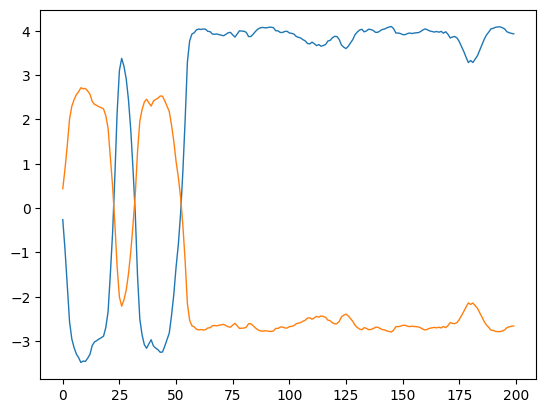

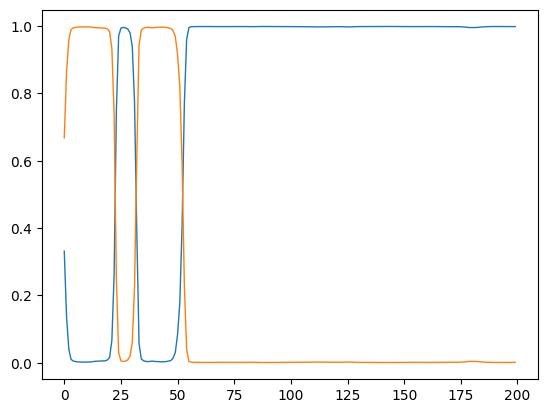

In [44]:
x = torch.FloatTensor(x_neural[0:200,:]).to(device)
z_enc = model.encoder(x.unsqueeze(0).unsqueeze(0))[0].squeeze()
z_trans = model.transition.step(z_enc.unsqueeze(0).unsqueeze(0)).squeeze()
y_prob = model.target_decoders['behavior'](z_enc.unsqueeze(0).unsqueeze(0)).squeeze()

print(y_prob.shape)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure()

for i in range(3):
    plt.plot(z_enc[:,i].detach().cpu().numpy(), color=colors[i], linewidth=1)
    plt.plot(z_trans[:,i].detach().cpu().numpy(), linestyle=':', color=colors[i])

plt.figure()
plt.plot(y_prob.detach().cpu().numpy(), linewidth=1)

plt.figure()
plt.plot(torch.softmax(y_prob, dim=-1).detach().cpu().numpy(), linewidth=1)
